In [18]:
options(warn=-1)

# load libraries 
library(igraph)
library(bootnet)
library(qgraph)
library(Hmisc)
library(ggplot2)
library(VIM)
library(gplots)
library(mice)
library(Rmisc)
library(dplyr)
library(data.table)
library(plotrix)

read, filter and split data using the most commonly used variables from the ssc data


 Variables sorted by number of missings: 
                        Variable Count
                             Sex     0
                    AQ_TestScore     0
           AQ_social_skill_score     0
    AQ_attention_switching_score     0
    AQ_attention_to_detail_score     0
          AQ_communication_score     0
            AQ_imagination_score     0
                    EQ_TestScore     0
                    SQ_TestScore     0
     EyesTest_Answered_Correctly     0
   EyesTest_Answered_Incorrectly     0
 RotationTest_Answered_Correctly     0
    RotationTest_Answered_Incorr     0
                   SPQ_TestScore     0
[1] "Total number of subjects before NA removal:  956"
[1] "Total number of subjects after NA removal:  956"
[1] "Male:  366"
[1] "Female:  590"
[1] "Total number of variables:  14"


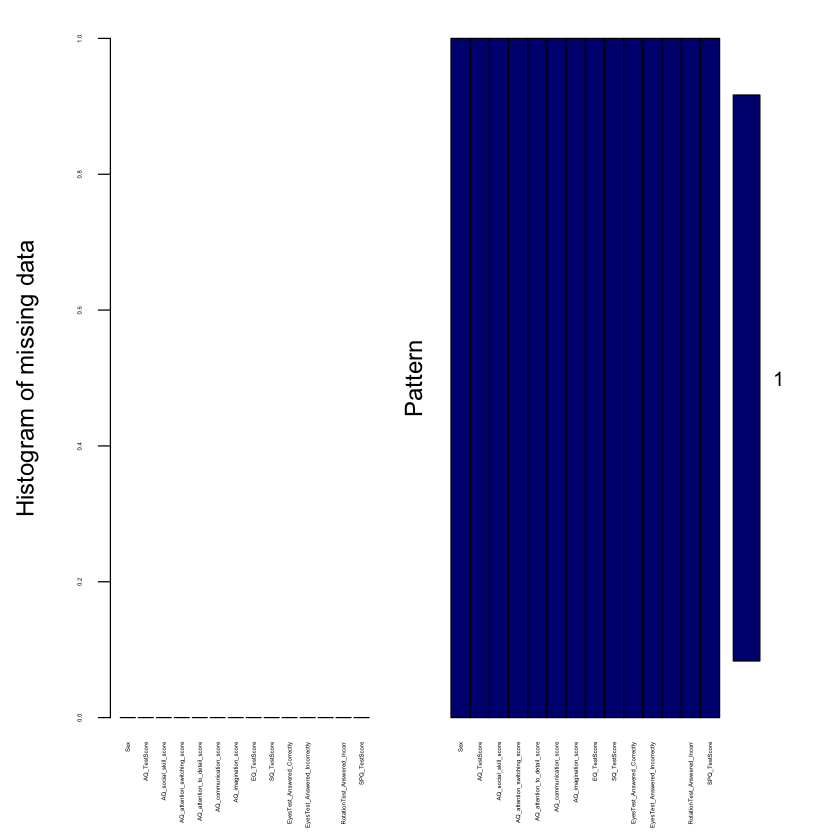

In [34]:
#if we already did the analysis then just reload it
if (file.exists("card.RData")) {
    # if the file exists we don't need to re-run most analysis later anyway and can go directly to plotting
    load(file="card.RData")
} else {

    df = read.csv("./Input/card.csv")
    
    # KDFE and matriced for nowR
    removeVar = grepl( "KDEF", names(df))
    df = df[,!removeVar]
    removeVar = grepl( "MatricesTest", names(df))
    df = df[,!removeVar]

    
    # OPTIONAL: remove the physiological measures
    df = subset(df, select=-c(volID,AQ_Age, EQ_Age, SQ_Age, EyesTest_Age, 
                              EyesTest_Not_Answered,
                              RotationTest_Age, RotationTest_Not_Answered, SPQ_Age, 
                              ShapesTest_Age, ShapesTest_Answered_Corr, ShapesTest_Not_Answered, ShapesTest_Answered_Incorr))

    #inspect completeness
    aggr_plot <- aggr(df, col=c('navyblue','red'), 
                  numbers=TRUE, sortVars=TRUE, 
                  labels=names(data), cex.axis=.3, 
                  gap=3, ylab=c("Histogram of missing data","Pattern"))

    print(paste("Total number of subjects before NA removal: ", toString(nrow(df))))
    #remove subjects with missing data
    df = df[complete.cases(df), ]
    print(paste("Total number of subjects after NA removal: ", toString(nrow(df))))

    #split genders
    df.M = subset(df, Sex == 'M')
    df.F = subset(df, Sex == 'F')    
    df.M = subset(df.M, select=-c(Sex))
    df.F = subset(df.F, select=-c(Sex))
    
}

#print some numbers to the console for verification
        print(paste("Male: ", toString(nrow(df.M))))
        print(paste("Female: ", toString(nrow(df.F))))
        print(paste("Total number of variables: ", toString(length(df))))

plot means and confidence intervals for each variable by group

pdf 
  2

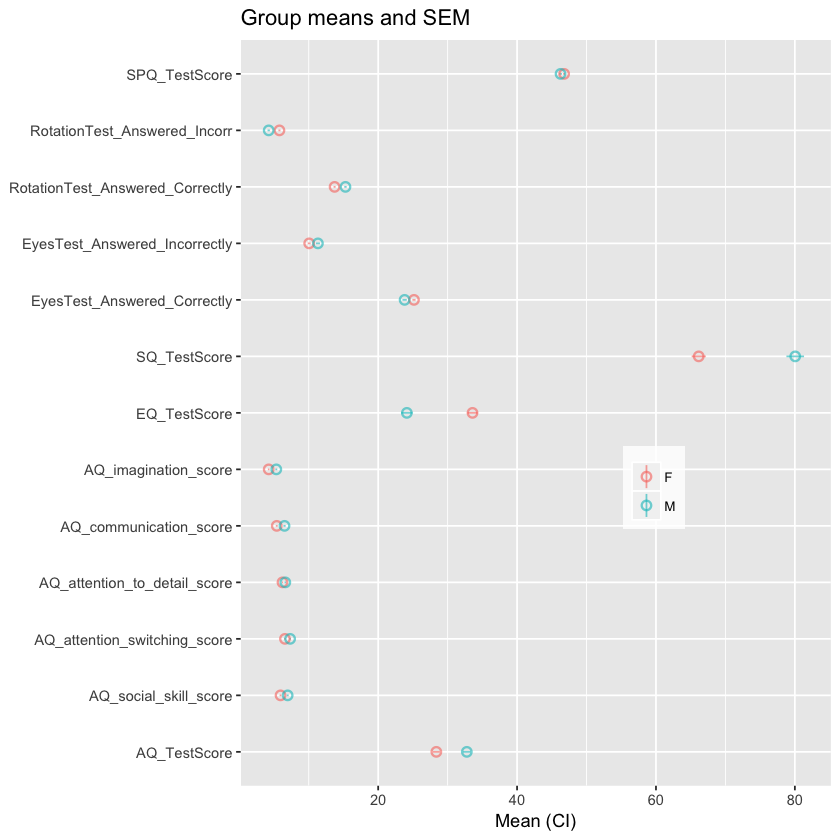

In [35]:
tempMean <- df %>% group_by(Sex) %>% summarise_all(funs(mean))
tempSD <- df %>% group_by(Sex) %>% summarise_all(funs(sd))
tempSEM <- df %>% group_by(Sex) %>% summarise_all(funs(std.error))

dfl1 <- melt(tempMean, id="Sex")
dfl2 <- melt(tempSD, id="Sex")
dfl3 <- melt(tempSEM, id="Sex")

ggplot(dfl1, aes(x=variable, y=value, ymin=(dfl1$value - dfl3$value), ymax=(dfl1$value + dfl3$value), color = Sex)) +
  geom_pointrange(alpha = 0.6, shape = 21) + 
  # geom_hline(yintercept=0, lty=2) +  # add a dotted line at x=1 after flip
  coord_flip() +  # flip coordinates (puts labels on y axis)
  ylab("Mean (CI)") + ggtitle('Group means and SEM') + 
  theme(axis.title.y=element_blank(),
        legend.position = c(0.7,0.4),
        legend.title = element_blank(),
        legend.text=element_text(size=8), 
        legend.background = element_rect(fill=alpha('white',0.8)))

pdf("./Output/Card_Descriptives.pdf",width=7,height=5)
ggplot(dfl1, aes(x=variable, y=value, ymin=(dfl1$value - dfl3$value), ymax=(dfl1$value + dfl3$value), color = Sex)) +
  geom_pointrange(alpha = 0.6, shape = 21) + 
  # geom_hline(yintercept=0, lty=2) +  # add a dotted line at x=1 after flip
  coord_flip() +  # flip coordinates (puts labels on y axis)
  ylab("Mean (CI)") + ggtitle('Group means and SEM') + 
  theme(axis.title.y=element_blank(),
        legend.position = c(0.7,0.4),
        legend.title = element_blank(),
        legend.text=element_text(size=8), 
        legend.background = element_rect(fill=alpha('white',0.8)))
dev.off()

estimate the networks

In [38]:
head(df.F)

,AQ_TestScore,AQ_social_skill_score,AQ_attention_switching_score,AQ_attention_to_detail_score,AQ_communication_score,AQ_imagination_score,EQ_TestScore,SQ_TestScore,EyesTest_Answered_Correctly,EyesTest_Answered_Incorrectly,RotationTest_Answered_Correctly,RotationTest_Answered_Incorr,SPQ_TestScore
1,11,2,3,5,0,1,40,48,23,13,10,10,49
3,14,2,5,4,3,0,48,71,15,21,17,3,46
7,16,3,4,6,0,3,62,60,31,5,8,12,39
9,38,6,9,7,9,7,17,65,20,9,16,3,52
11,10,3,3,3,0,1,52,37,26,10,12,8,47
17,13,2,3,6,1,1,55,30,24,11,12,7,47


In [42]:
    df.M.Network <- estimateNetwork(df.M, default = "IsingFit")
    df.F.Network <- estimateNetwork(df.F, default = "IsingFit")

Estimating Network. Using package::function:
  - IsingFit::IsingFit for network computation
    - Using glmnet::glmnet


  |======================================================================| 100%


Estimating Network. Using package::function:
  - IsingFit::IsingFit for network computation
    - Using glmnet::glmnet


  |======================================================================| 100%


pdf 
  2

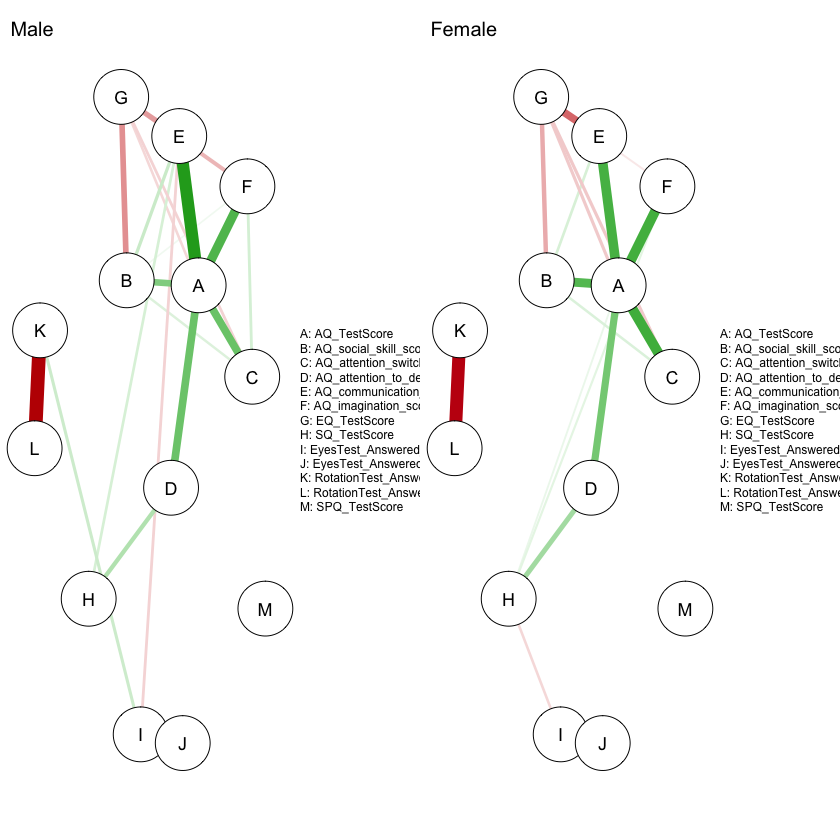

In [43]:
# network plots
# graph in same layout
Layout <- averageLayout(df.M.Network,df.F.Network)
layout(t(1:2))

Labels <- LETTERS[1:length(df.M.Network$labels)]
Names <- df.M.Network$labels


qgraph(df.M.Network$graph, layout = Layout, labels = Labels, 
     title = 'Male', nodeNames = Names, legend.cex = 0.3)
qgraph(df.F.Network$graph, layout = Layout, labels = Labels, 
     title = 'Female', nodeNames = Names, legend.cex = 0.3)

pdf("./Output/Card_Networks.pdf",width=7,height=5)
qgraph(df.M.Network$graph, layout = Layout, labels = Labels, 
     title = 'Male', nodeNames = Names, legend.cex = 0.3)
qgraph(df.F.Network$graph, layout = Layout, labels = Labels, 
     title = 'Female', nodeNames = Names, legend.cex = 0.3)
dev.off()

Note: z-scores are shown on x-axis rather than raw centrality indices.
Note: z-scores are shown on x-axis rather than raw centrality indices.


pdf 
  2

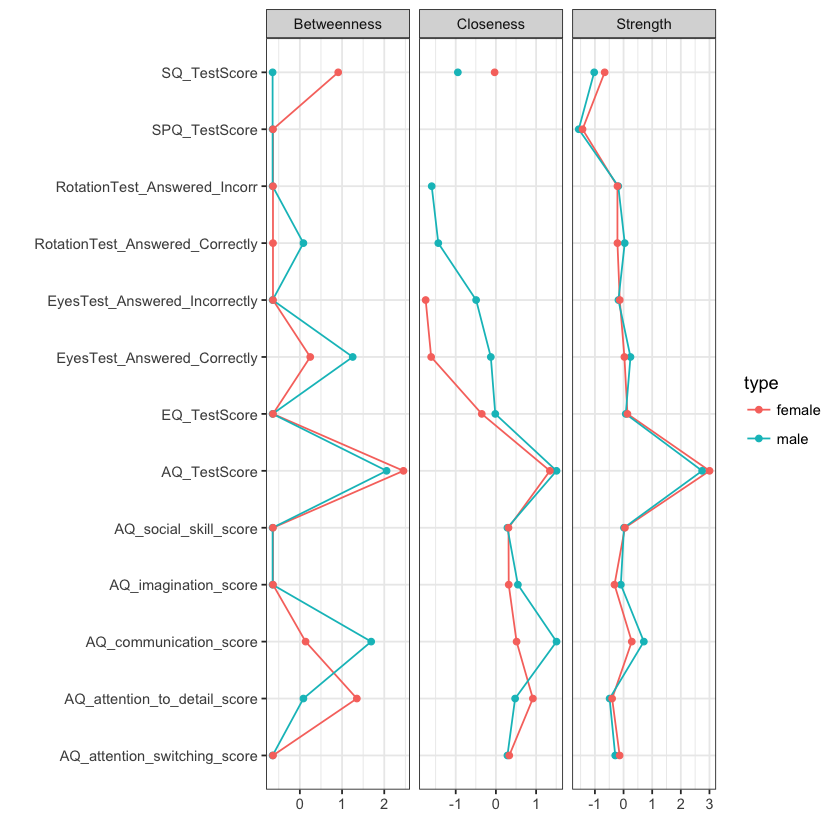

In [44]:
# centrality plots comparing groups
centralityPlot(GGM = list(male = df.M.Network, female = df.F.Network))

pdf("./Output/Card_Centrality.pdf",width=7,height=5)
    centralityPlot(GGM = list(male = df.M.Network, female = df.F.Network))
dev.off()

bootstrap the network edges - THIS WILL TAKE QUITE LONG!!

In [45]:
if (exists("df.M.boot1")){
    print("No need to re-bootstrap, already done!")
} else {
    df.M.boot1 <- bootnet(df.M.Network, nBoots = 1000,  nCores = 6)
    df.F.boot1 <- bootnet(df.F.Network, nBoots = 1000,  nCores = 6)
}

Estimating sample network...
Estimating Network. Using package::function:
  - IsingFit::IsingFit for network computation
    - Using glmnet::glmnet


  |======================================================================| 100%


Bootstrapping...
Computing statistics...
Estimating sample network...
Estimating Network. Using package::function:
  - IsingFit::IsingFit for network computation
    - Using glmnet::glmnet


  |======================================================================| 100%


Bootstrapping...
Computing statistics...


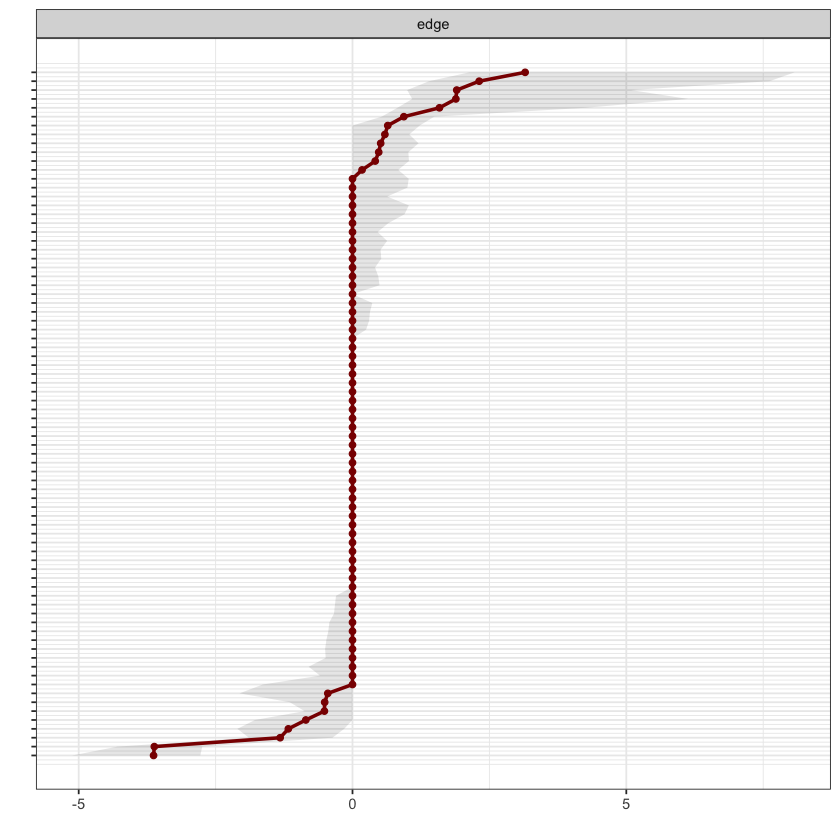

pdf 
  2

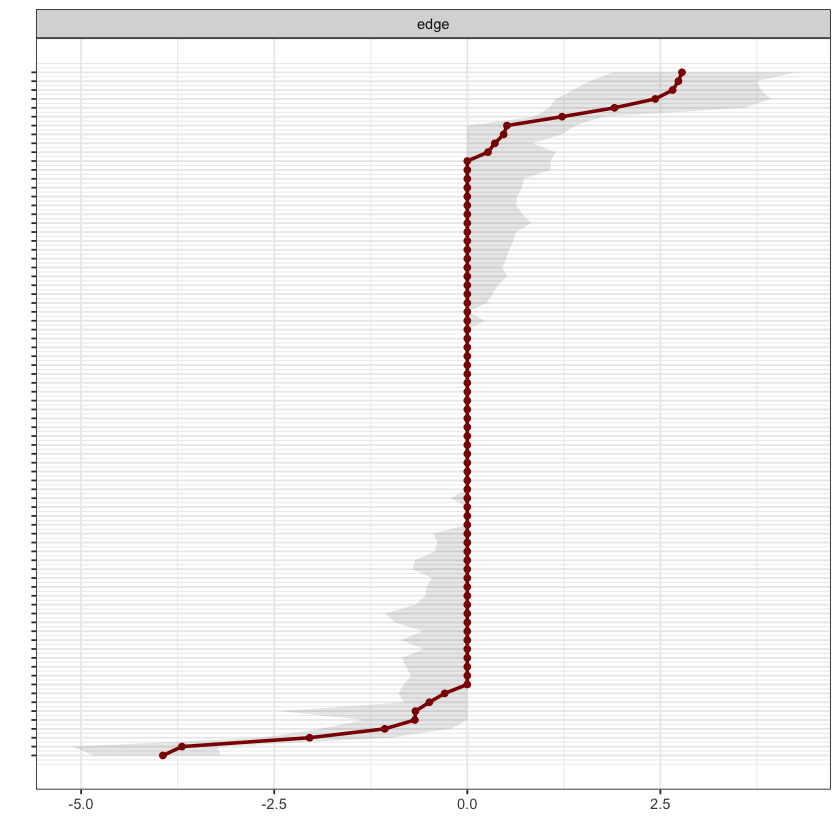

In [46]:
#plot the bootstrapped confidence intervals
plot(df.M.boot1, labels = FALSE, order = "sample", title = "Male")
plot(df.F.boot1, labels = FALSE, order = "sample", title = "Female")

pdf("./Output/Card_BootstrappedCI.pdf",width=7,height=5)
    plot(df.M.boot1, labels = FALSE, order = "sample", title = "Male")
    plot(df.F.boot1, labels = FALSE, order = "sample", title = "Female")
dev.off()

Expected significance level given number of bootstrap samples is approximately: 0.002


Expected significance level given number of bootstrap samples is approximately: 0.002


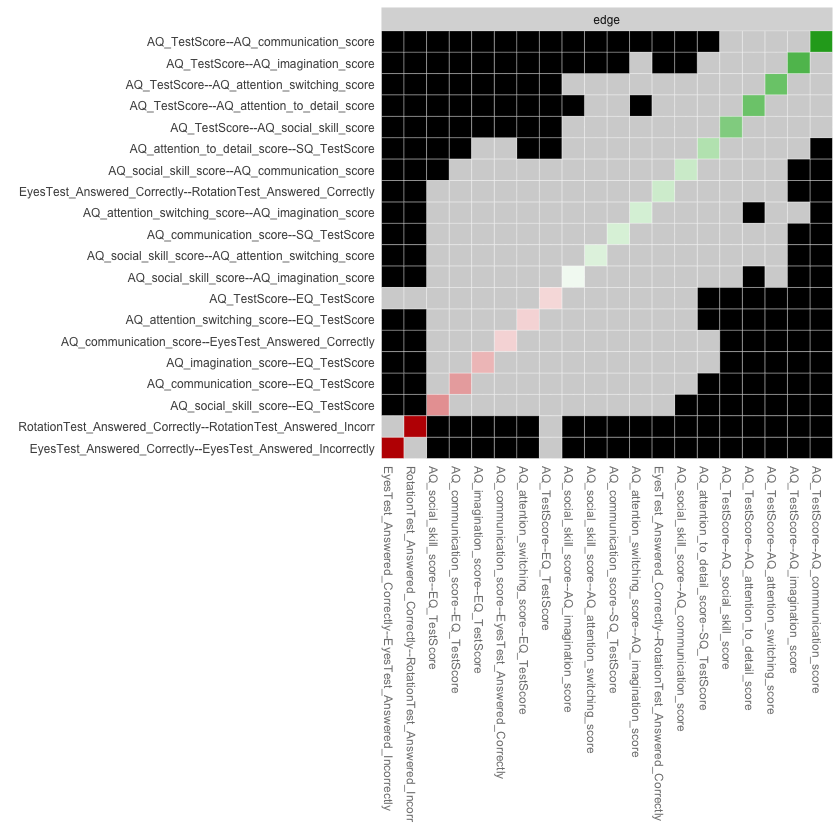

Expected significance level given number of bootstrap samples is approximately: 0.002


Expected significance level given number of bootstrap samples is approximately: 0.002


pdf 
  2

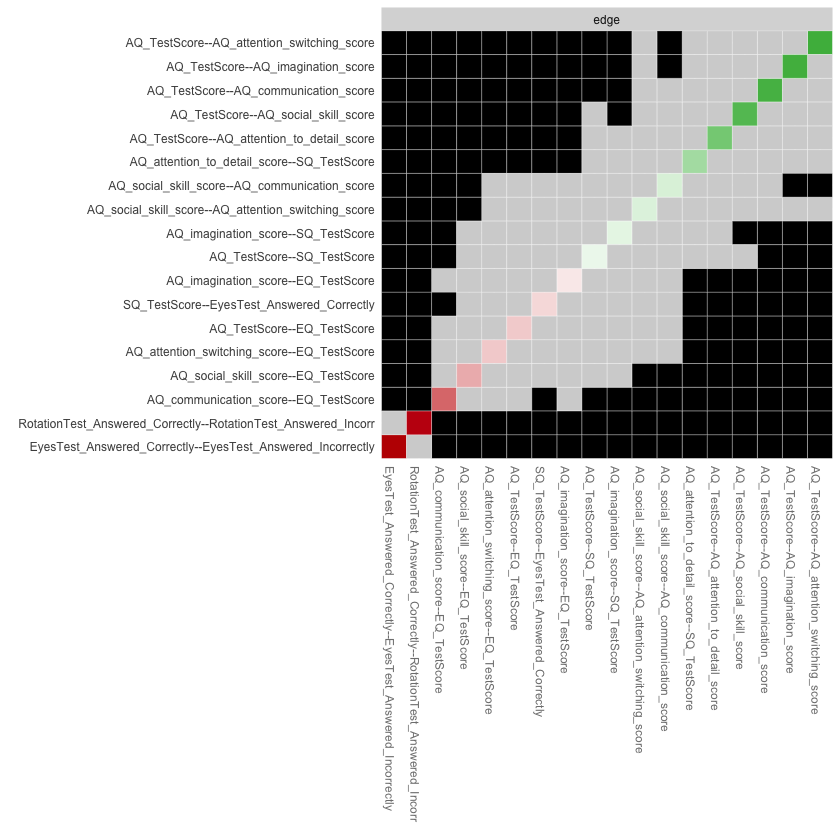

In [47]:
#plot boostrapped significant edge differences
plot(df.M.boot1, "edge", plot = "difference", onlyNonZero = TRUE,
     order = "sample", alpha = 0.001, title = "Male")
plot(df.F.boot1, "edge", plot = "difference", onlyNonZero = TRUE,
     order = "sample", alpha = 0.001, title = "Female")

pdf("./Output/Card_BootstrappedEdgeDiff.pdf",width=7,height=5)
    plot(df.M.boot1, "edge", plot = "difference", onlyNonZero = TRUE,
     order = "sample", alpha = 0.001, title = "Male")
    plot(df.F.boot1, "edge", plot = "difference", onlyNonZero = TRUE,
     order = "sample", alpha = 0.001, title = "Female")
dev.off()

Expected significance level given number of bootstrap samples is approximately: 0.0019


Expected significance level given number of bootstrap samples is approximately: 0.002


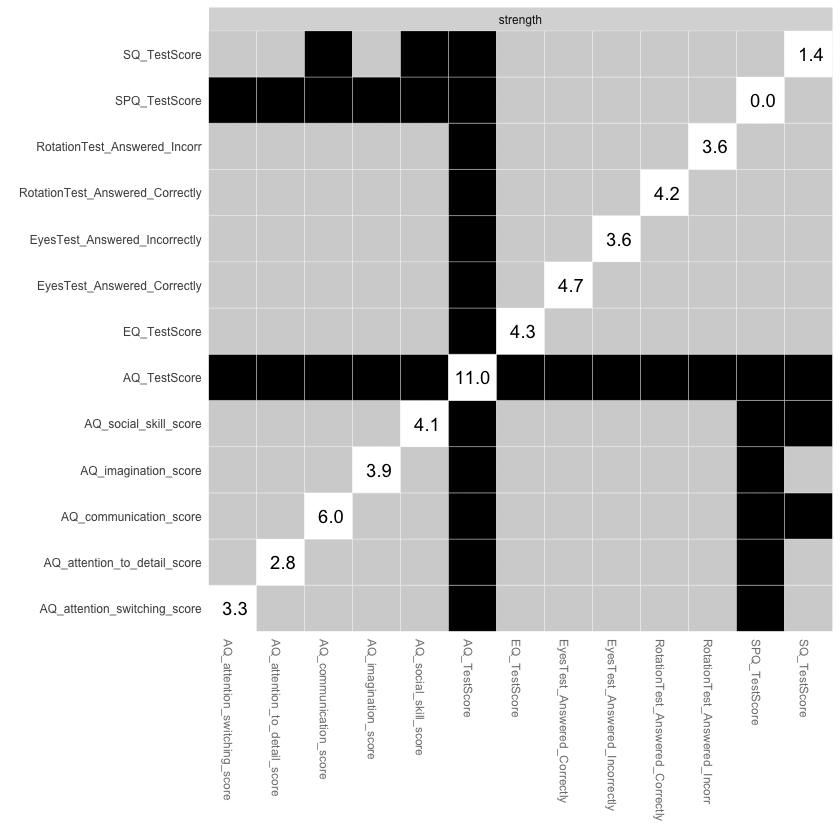

Expected significance level given number of bootstrap samples is approximately: 0.002


Expected significance level given number of bootstrap samples is approximately: 0.002


pdf 
  2

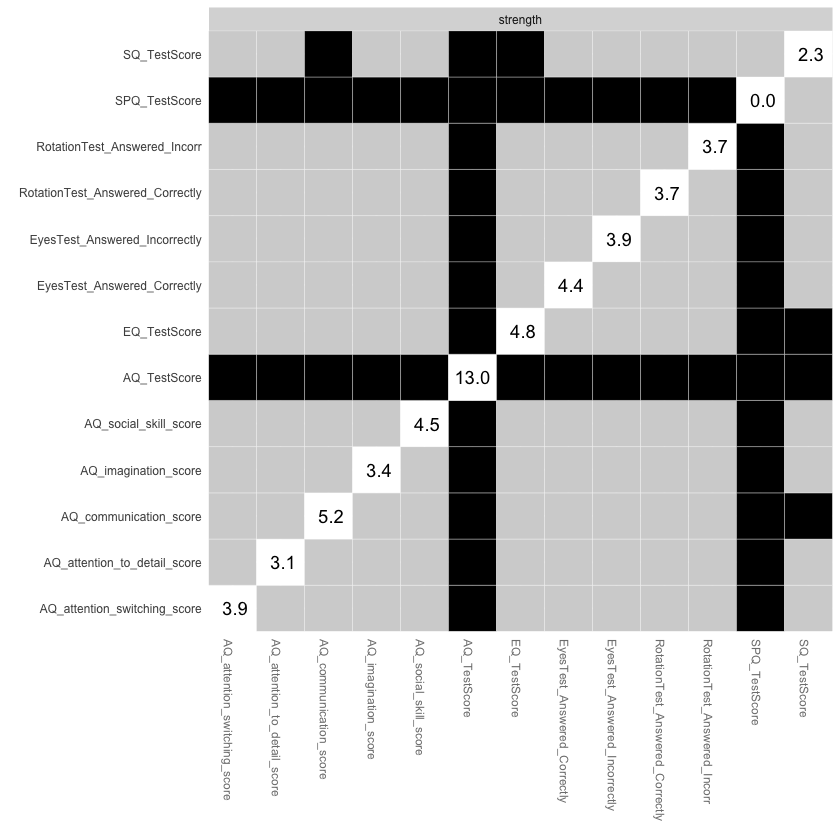

In [48]:
#plot boostrapped significant nodal strength differences
    plot(df.M.boot1, "strength", alpha = 0.001,title = "Male")
    plot(df.F.boot1, "strength", alpha = 0.001,title = "Female")

pdf("./Output/Card_StrengthDiff.pdf",width=7,height=5)
    plot(df.M.boot1, "strength", alpha = 0.001,title = "Male")
    plot(df.F.boot1, "strength", alpha = 0.001,title = "Female")
dev.off()

In [49]:
# save intermediate steps for later
save.image(file="card.RData")

bootstrap the networks centrality measures - this might take a while

In [50]:
if (exists("df.M.boot2")){
    print("No need to re-bootstrap, already done!")
} else {
    df.M.boot2 <- bootnet(df.M.Network, type = "case", nBoots = 1000,  nCores = 6)
    df.F.boot2 <- bootnet(df.F.Network, type = "case", nBoots = 1000,  nCores = 6)
}

Estimating sample network...
Estimating Network. Using package::function:
  - IsingFit::IsingFit for network computation
    - Using glmnet::glmnet


  |======================================================================| 100%


Bootstrapping...
Computing statistics...
Estimating sample network...
Estimating Network. Using package::function:
  - IsingFit::IsingFit for network computation
    - Using glmnet::glmnet


  |======================================================================| 100%


Bootstrapping...
Computing statistics...


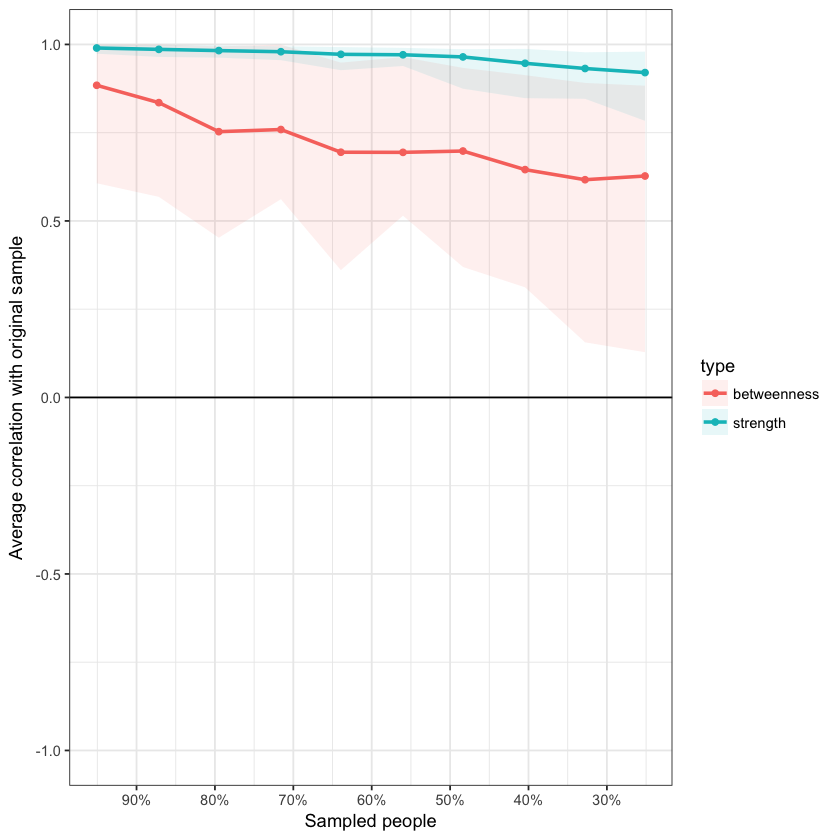

pdf 
  2

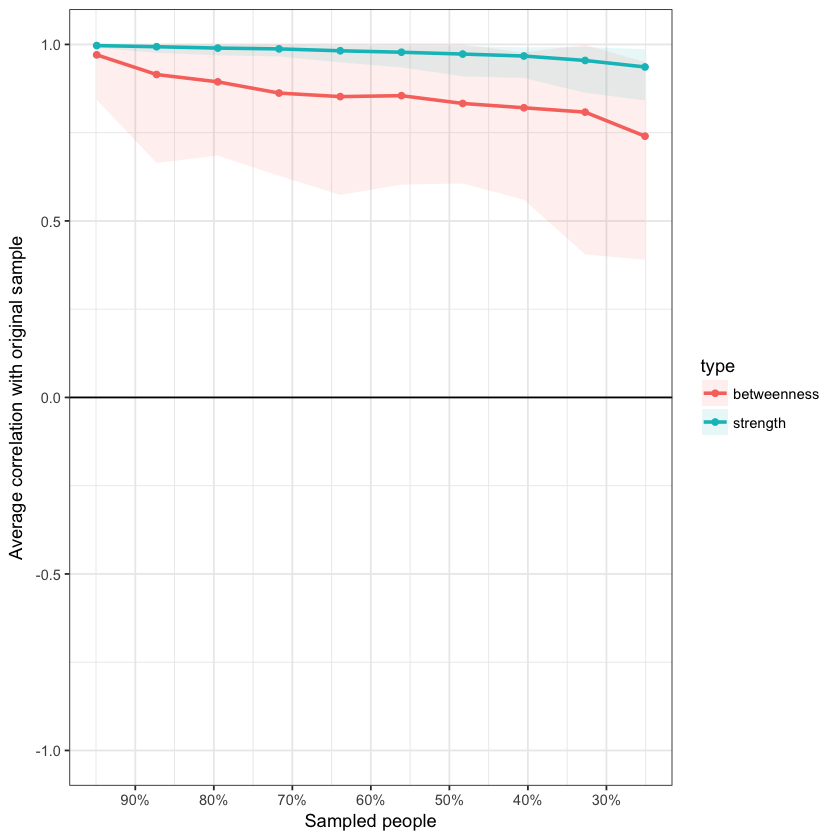

In [51]:
#plot the bootstrapped centrality indices
    plot(df.M.boot2, title = "Male")
    plot(df.F.boot2, title = "Female")

pdf("./Output/CentralityBoot.pdf",width=7,height=5)
    plot(df.M.boot2, title = "Male")
    plot(df.F.boot2, title = "Female")
dev.off()

check the stability of all centrality measures

In [52]:
corStability(df.M.boot2)
corStability(df.F.boot2)

=== Correlation Stability Analysis === 

Sampling levels tested:
   nPerson Drop%   n
1       92  74.9 109
2      120  67.2  98
3      148  59.6 102
4      177  51.6  95
5      205  44.0  95
6      234  36.1  95
7      262  28.4 103
8      291  20.5 106
9      319  12.8 107
10     348   4.9  90

Maximum drop proportions to retain correlation of 0.7 in at least 95% of the samples:

betweenness: 0
  - For more accuracy, run bootnet(..., caseMin = 0, caseMax = 0.049) 

closeness: 0
  - For more accuracy, run bootnet(..., caseMin = 0, caseMax = 0.049) 

strength: 0.749
  - For more accuracy, run bootnet(..., caseMin = 0.672, caseMax = 1) 

Accuracy can also be increased by increasing both 'nBoots' and 'caseN'.=== Correlation Stability Analysis === 

Sampling levels tested:
   nPerson Drop%   n
1      148  74.9 105
2      193  67.3 102
3      239  59.5  94
4      285  51.7  99
5      331  43.9 109
6      377  36.1  88
7      423  28.3 119
8      469  20.5  87
9      515  12.7 102
10     560

In [53]:
# save intermediate steps for later
save.image(file="card.RData")